In [1]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.contrib import rnn
from utils import myplot

/home/zrz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class DuRNN(object):
    def __init__(self, session, learning_rate, batch_size, seq_len, feat_size, hidden_size, device='/gpu:0'):
        self.batch_size = batch_size
        self.T = seq_len
        self.n = feat_size
        self.hidden_size = hidden_size
        
        # for train
        self.session = session
        self.learning_rate = learning_rate
        
        with tf.device(device):
            self.init_input()
            self.init_nn()
            self.init_op()
    
    def init_input(self):
        self.x = tf.placeholder(tf.float32, [None, self.T, self.n])
        self.y = tf.placeholder(tf.float32, [None, self.T-1])
        self.label = tf.placeholder(tf.float32, [None, 1])
        
    def init_nn(self):
        
        # encode
        with tf.variable_scope("encode"):
            h_list = []
            h_state = tf.zeros([self.batch_size, self.hidden_size])
            s_e_state = tf.zeros([self.batch_size, self.hidden_size])
            encode_lstm = tf.nn.rnn_cell.LSTMCell(self.hidden_size, name='basic_lstm_cell')
            w_e = tf.Variable(tf.random_normal([2*self.hidden_size, self.T]), name="w_e")
            u_e = tf.Variable(tf.random_normal([self.T, self.T]), name="u_e")
            v_e = tf.Variable(tf.random_normal([self.T, 1]), name="v_e")
            for t in range(self.T):
                # b * n * h
                h_state_sparse, s_e_state_sparse = tf.reshape(h_state, [-1, 1, self.hidden_size]), tf.reshape(s_e_state, [-1, 1, self.hidden_size])
                h_state_repeat = tf.concat([h_state_sparse]*self.n, axis=1)
                s_e_state_repeat = tf.concat([s_e_state_sparse]*self.n, axis=1)
                # ((b*n) * (2*h)) * ((2*h) * T) = (b*n) * T
                # h_s_attn = tf.matmul(tf.reshape(tf.concat([h_state_repeat, s_e_state_repeat], axis=2), [self.batch_size*self.n, 2*self.hidden_size]), w_e)
                h_s_attn = tf.matmul(tf.reshape(tf.concat([h_state_repeat, s_e_state_repeat], axis=2), [-1, 2*self.hidden_size]), w_e)
                # ((b*n) * T) * (T * T) = (b*n) * T
                # e_attn = tf.matmul(tf.reshape(tf.transpose(self.x, [0, 2, 1]), [self.batch_size*self.n, self.T]), u_e)
                e_attn = tf.matmul(tf.reshape(tf.transpose(self.x, [0, 2, 1]), [-1, self.T]), u_e)
                # ((b*n) * T) * (T * 1) = (b*n) * 1
                e_t = tf.matmul(tf.nn.tanh(h_s_attn + e_attn), v_e)
                # e_t = tf.reshape(e_t, [self.batch_size, self.n])
                e_t = tf.reshape(e_t, [-1, self.n])
                alpha_t = tf.nn.softmax(e_t, axis=1)
                # alpha_t = tf.reshape(alpha_t, [self.batch_size, 1, self.n])
                # x = tf.multiply(tf.reshape(self.x[:,t,:], [self.batch_size, self.n]), alpha_t)
                x = tf.multiply(tf.reshape(self.x[:,t,:], [-1, self.n]), alpha_t)
                initial_state = (h_state, s_e_state)
                _, (h_state, s_e_state) = tf.nn.static_rnn(encode_lstm, [x], initial_state=initial_state, dtype=tf.float32)
                # h_state, s_e_state = tf.reshape(h_state, [self.batch_size, self.hidden_size]), tf.reshape(s_e_state, [self.batch_size, self.hidden_size])
                # h_list.append(tf.reshape(h_state, [self.batch_size, 1, self.hidden_size]))
                h_state, s_e_state = tf.reshape(h_state, [-1, self.hidden_size]), tf.reshape(s_e_state, [-1, self.hidden_size])
                h_list.append(tf.reshape(h_state, [-1, 1, self.hidden_size]))
        
        with tf.variable_scope("decode"):
            # h = tf.concat(h_list, dim=1)
            d_state = tf.zeros([self.batch_size, self.hidden_size])
            s_d_state = tf.zeros([self.batch_size, self.hidden_size])
            decode_lstm = tf.nn.rnn_cell.LSTMCell(self.hidden_size)
            w_d = tf.Variable(tf.random_normal([2*self.hidden_size, self.hidden_size]), name="w_d")
            u_d = tf.Variable(tf.random_normal([self.hidden_size, self.hidden_size]), name="u_d")
            v_d = tf.Variable(tf.random_normal([self.hidden_size, 1]), name="v_d")
            w_y = tf.Variable(tf.random_normal([self.hidden_size+1, 1]), name="w_y")
            b_y = tf.Variable(tf.random_normal([self.batch_size, 1]), name="b_y")
            for t in range(self.T-1):

                d_state_sparse, s_d_state_sparse = tf.reshape(d_state, [-1, 1, self.hidden_size]), tf.reshape(s_d_state, [-1, 1, self.hidden_size])
                # b * T * h
                d_state_repeat = tf.concat([d_state_sparse]*self.T, axis=1)
                s_d_state_repeat = tf.concat([s_d_state_sparse]*self.T, axis=1)

                # ((b*T) * (2*h)) * ((2*h) * h) = (b*T) * h
                # d_s_attn = tf.matmul(tf.reshape(tf.concat([d_state_repeat, s_d_state_repeat], axis=2), [self.batch_size*self.T, 2*self.hidden_size]), w_d)
                d_s_attn = tf.matmul(tf.reshape(tf.concat([d_state_repeat, s_d_state_repeat], axis=2), [-1, 2*self.hidden_size]), w_d)
                # ((b*T) * h) * (h * h) = (b*T) * h
                # e_d_attn = tf.matmul(tf.reshape(tf.concat(h_list, axis=1), [self.batch_size*self.T, self.hidden_size]), u_d)
                e_d_attn = tf.matmul(tf.reshape(tf.concat(h_list, axis=1), [-1, self.hidden_size]), u_d)
                # ((b*T) * h) * (h * 1) = (b*T) * 1
                l_t = tf.matmul(tf.nn.tanh(d_s_attn + e_d_attn), v_d)
                # l_t = tf.reshape(l_t, [self.batch_size, self.T])
                l_t = tf.reshape(l_t, [-1, self.T])
                beta_t = tf.nn.softmax(l_t, axis=1)
                
                # (b * T * h) x (b * T * h)
                c_t = tf.multiply(
                    tf.concat(h_list, axis=1),
                    tf.concat([tf.reshape(beta_t, [-1, self.T, 1])]*self.hidden_size, axis=2)
                )
                # (b * h)
                c_t = tf.reduce_sum(c_t, axis=1)
                # (b * (m+1)) * ((m+1) * 1) = (b * 1)
                # if t == 0:
                #     y_t_ = tf.matmul(tf.concat([tf.zeros([self.batch_size, 1]), c_t], axis=1), w_y) + b_y
                # else:
                #     y_t_ = tf.matmul(tf.concat([tf.reshape(self.y[:,t-1], [self.batch_size, 1]), c_t], axis=1), w_y) + b_y
                # y_t_ = tf.matmul(tf.concat([tf.reshape(self.y[:,t], [self.batch_size, 1]), c_t], axis=1), w_y) + b_y
                y_t_ = tf.matmul(tf.concat([tf.reshape(self.y[:,t], [-1, 1]), c_t], axis=1), w_y) + b_y
                initial_state = (d_state, s_d_state)
                _, (d_state, s_d_state) = tf.nn.static_rnn(decode_lstm, [y_t_], initial_state=initial_state, dtype=tf.float32)
                # d_state, s_d_state = tf.reshape(d_state, [self.batch_size, self.hidden_size]), tf.reshape(s_d_state, [self.batch_size, self.hidden_size])
                d_state, s_d_state = tf.reshape(d_state, [-1, self.hidden_size]), tf.reshape(s_d_state, [-1, self.hidden_size])
                
        w_o = tf.Variable(tf.random_normal([2*self.hidden_size, self.hidden_size]), name="w_o")
        b_o = tf.Variable(tf.random_normal([self.hidden_size]), name="b_o")
        w_v = tf.Variable(tf.random_normal([self.hidden_size, 1]), name="w_v")
        b_v = tf.Variable(tf.random_normal([1]), name="b_v")
        # (b * 2h) * (2h * h) *(h * 1)
        self.pred_y = tf.matmul(tf.matmul(tf.concat([d_state, s_d_state], axis=1), w_o) + b_o, w_v) + b_v
        # print(self.pred_y)
    
    def init_op(self):
        with tf.variable_scope('loss'):
            self.loss = tf.losses.mean_squared_error(self.pred_y, self.label)
            # self.loss = tf.reduce_mean(tf.square(self.pred_y - self.label) / tf.abs(self.label))
        with tf.variable_scope('train'):
            self.global_step = tf.Variable(0, trainable=False)
            self.decay_learning_rate = tf.train.exponential_decay(self.learning_rate, self.global_step, 1000, 0.92)
            self.optimizer = tf.train.RMSPropOptimizer(self.decay_learning_rate)
            self.train_op = self.optimizer.minimize(self.loss, global_step=self.global_step)
        self.session.run(tf.global_variables_initializer())

    def train(self, train_data, valid_data, epoches=10):
        steps = 0
        epoch = 0
        while epoch < epoches:
            for batch_x, batch_y, batch_label in get_batch(train_data, self.batch_size, False):
                _, loss, lr = self.session.run([self.train_op, self.loss, self.decay_learning_rate], feed_dict={self.x: batch_x,
                                                                                  self.y: batch_y,
                                                                                  self.label: batch_label
                                                                                 })
                if steps % 300 == 0:
                    logging.warning("Epoch: {0} Step: {1} | Loss: {2:.7f} | LR: {3}".format(epoch, steps, loss, lr))
                if steps % 600 == 0:
                    self.valid(valid_data)
                steps += 1
            epoch += 1
    
    def valid(self, data):
        losses = []
        for batch_x, batch_y, batch_label in get_batch(data, self.batch_size, False):
            loss = self.session.run(self.loss, feed_dict={self.x: batch_x,
                                                            self.y: batch_y,
                                                            self.label: batch_label
                                                           })
            losses.append(loss)
        logging.warning("valid loss: %.7f", sum(losses) / len(losses))
    
    def predict(self, data):
        preds = []
        for batch_x, batch_y, batch_label in get_batch(data, self.batch_size, False):
            pred = self.session.run(self.pred_y, feed_dict={self.x: batch_x, self.y: batch_y})
            preds.append(pred)
        return np.concatenate(preds)
        
            

In [3]:
def evaluate(label, pred):
    myplot([label, pred], labels=['truth', 'pred'])
    length = min(len(label), len(pred))
    rmse = np.sqrt(sum([(label[i] - pred[i])**2 for i in range(length)]) / length)
    print("rmse:", rmse)

In [4]:
def get_data(path="data/nasdaq100_padding.csv"):
    raw_data = pd.read_csv(path)
    rt_data = raw_data.copy(True)
    scaler = StandardScaler().fit(rt_data)
    rt_data = scaler.transform(rt_data)
    # rt_data = pd.DataFrame(rt_data, columns=raw_data.columns)
    scaler_idx = StandardScaler().fit(raw_data['NDX'].to_frame())
    return raw_data.values, rt_data, scaler_idx

In [5]:
def inverse_transform(pred, scaler):
    mean_ = scaler.mean_
    scale_ = scaler.scale_
    raw_pred = [p * scale_ + mean_ for p in pred]
    return raw_pred

In [6]:
def form_data(data):
    start = seq_len
    end = start+seq_len
    x, y, label = [], [], []
    while end < data.shape[0]:
        x.append(data[start:end,:feat_size])
        y.append(data[start:end-1,feat_size])
        label.append(data[end-1,feat_size].reshape(1))
        start += 1
        end += 1
    return np.array(x), np.array(y), np.array(label)

In [7]:
def get_batch(data, batch_size, shuffle=True):
    x, y, label = data
    if shuffle:
        days_x = np.array([x[i*390:(i+1)*390] for i in range(len(x) // 390)])
        days_y = np.array([y[i*390:(i+1)*390] for i in range(len(y) // 390)])
        days_label = np.array([label[i*390:(i+1)*390] for i in range(len(label) // 390)])
        idx = [i for i in range(len(days_x))]
        np.random.shuffle(idx)
        days_x, days_y, days_label = days_x[idx], days_y[idx], days_label[idx]
        x, y, label = [], [], []
        for i in range(len(days_x)):
            x.extend(days_x[i])
            y.extend(days_y[i])
            label.extend(days_label[i])
    start = 0
    end = batch_size
    while end < len(x):
        b_x = x[start:end]
        b_y = y[start:end]
        b_label = label[start:end]
        start = end
        end = start + batch_size
        yield b_x, b_y, b_label

In [8]:
learning_rate = 0.005
batch_size = 128
seq_len = 10
feat_size = 81
hidden_size = 64
raw_data, scale_data, scaler = get_data()
x, y, label = form_data(scale_data)
# train_end = int(0.8 * len(x))
# valid_end = int(0.9 * len(x))
train_end = 35100
valid_end = 35100 + 2730
train_data = (x[:train_end]+0.8, y[:train_end]+0.8, label[:train_end]+0.8)
valid_data = (x[train_end:valid_end], y[train_end:valid_end], label[train_end:valid_end])
test_data = x[valid_end:], y[valid_end:], label[valid_end:]
print("train_data:", len(train_data[0]))
print("valid_data:", len(valid_data[0]))
print("test_data:", len(test_data[0]))

x_raw, y_raw, label_raw = form_data(raw_data)
valid_data_raw = x_raw[train_end:valid_end], y_raw[train_end:valid_end], label_raw[train_end:valid_end]
test_data_raw = x_raw[valid_end:], y_raw[valid_end:], label_raw[valid_end:]

train_data: 35100
valid_data: 2730
test_data: 2710


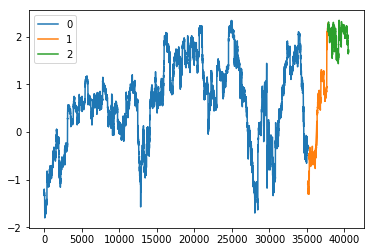

In [9]:
myplot([train_data[2], valid_data[2], test_data[2]], xs=[range(train_end), range(train_end, valid_end), range(valid_end,valid_end+len(test_data[2]))])

In [12]:
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
model = DuRNN(tf.Session(config=config), learning_rate, batch_size, seq_len, feat_size, hidden_size)

In [13]:
model.train(train_data, valid_data, 300)

rmse: [0.02674186]


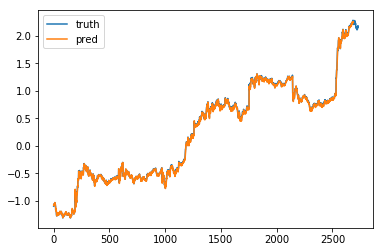

In [14]:
pred_label = model.predict(valid_data)
evaluate(valid_data[2], pred_label)

rmse: [1.69234631]


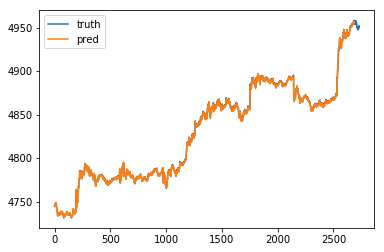

In [15]:
price = inverse_transform(pred_label, scaler)
valid_price = inverse_transform(valid_data[2].reshape(valid_data[2].shape[0]), scaler)
evaluate(valid_price, price)

rmse: [0.02545343]


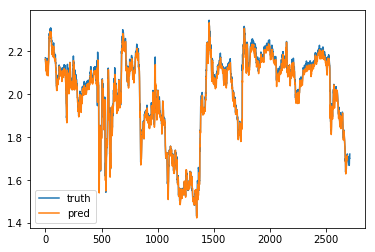

In [16]:
pred_label = model.predict(test_data)
evaluate(test_data[2],pred_label)

rmse: [1.61080854]


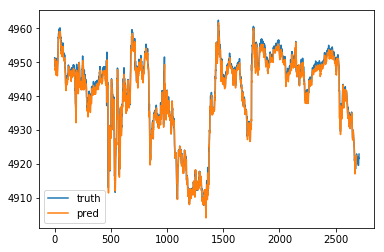

In [17]:
price = inverse_transform(pred_label, scaler)
test_price = inverse_transform(test_data[2].reshape(test_data[2].shape[0]), scaler)
evaluate(test_price, price)